In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def shaded_kde_plot(values, ax = None, label = None, bw: float = 0.3, x_money_ticks: bool = True, **params):
    values = values.tolist()
    if not ax:
        fig, ax = plt.subplots(figsize=(14, 6))
    sns.kdeplot(values, ax=ax, legend=False, label=label, bw=bw, **params)
    color=ax.get_lines()[-1].get_color()
    x = ax.lines[-1].get_xdata()
    y = ax.lines[-1].get_ydata()
    mean = np.median(values)
    ax.vlines(mean, 0, np.interp(mean, x, y), linestyle='--', alpha=0.2, color=color)
    ax.fill_between(x, 0, y, color=color, alpha=0.2)
    if x_money_ticks:
        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))

# UC Physician Salaries
    

In [4]:
import requests
import time

from bs4 import BeautifulSoup as soup
from tqdm.notebook import tqdm

In [5]:
def name_token_search(salary_data, name):
    found_people = salary_data.loc[salary_data["employee_name"].apply(lambda s: search_token in s.lower())]

In [6]:
def find_provider_salaries(provider_data: pd.DataFrame, salary_data: pd.DataFrame):
    """"""
    found_providers, name_data = [], []
    for i, provider_data_row in provider_data.iterrows():
        provider_name = provider_data_row["name"]
        last_name = provider_name.split(" ")[-1]
        found_people = salary_data.loc[salary_data["employee_name"].apply(lambda s: s.endswith(last_name))]

        first_name = provider_name.split(" ")[0]
        found_people = found_people.loc[found_people["employee_name"].apply(lambda s: s.startswith(first_name))]

        if len(found_people) > 1:
            exact_matches = found_people["employee_name"] == provider_name.replace(".", "")
            if any(exact_matches):
                found_people = found_people.loc[exact_matches]

        if len(found_people) > 1:
            pass
#             print(f"More than one listing found for name: {provider_name}")
        elif len(found_people) == 0:
            pass
#             print(f"No listing found for name: {provider_name}")
        else:
            found_providers.append(found_people)
            name_data.append(provider_data_row)

    found_providers = pd.concat(found_providers)
    name_data = pd.concat(name_data, axis=1).transpose()

    for col in name_data.columns:
        found_providers[col] = name_data[col].values
    return found_providers

In [11]:
salary_data = pd.read_csv("transparent_california_data/university-of-california-2019.csv")
salary_data.columns = [col.lower().strip().replace(" ", "_") for col in salary_data.columns]
salary_data = salary_data.query('base_pay > 100_000').copy(deep=True)
for remove_tokens in ["recall", "ofcr", "admin", "resid"]:
    salary_data = salary_data.loc[~salary_data["job_title"].apply(lambda s: remove_tokens in s.lower())].copy(deep=True)
salary_data["total_pay"] = salary_data["total_pay_&_benefits"] - salary_data["benefits"]

C:\Users\Cole\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
DEPARTMENT_URLS = {
    "neurosurgery": "https://neurosurgery.ucsf.edu/faculty",
    "cardiology": "https://ucsfhealthcardiology.ucsf.edu/people",
    "ophthalmology": "https://ophthalmology.ucsf.edu/all-faculty/",
    "hematology / oncology": "https://ucsfhealthhemonc.ucsf.edu/people?combine=&page={page_number}",
    "otolaryngology": "https://ohns.ucsf.edu/people",
    "pediatrics": "https://pediatrics.ucsf.edu/pediatrics/faculty/{page_letter}",
    "nephrology": "https://nephrology.ucsf.edu/people?combine=&page={page_number}",
    "gastroenterology": "https://gastroenterology.ucsf.edu/people?combine=&page={page_number}",
    "psychiatry": "https://psychiatry.ucsf.edu/faculty",
    "neurology": "https://neurology.ucsf.edu/faculty",
    "emergency medicine": "https://emergency.ucsf.edu/people",
    "pulmonology": "https://pulmonary.ucsf.edu/people?combine=&page={page_number}",
    "infectious diseases": "https://infectiousdiseases.ucsf.edu/people?combine=&page={page_number}",
    "anesthesiology": "https://anesthesia.ucsf.edu/people/faculty?page={page_number}",
    "dermatology": "http://www.dermatology.ucsf.edu/adult-dermatology-1",
    "pathology": "https://pathology.ucsf.edu/about/faculty/faculty-directory",
    "family medicine": "https://fcm.ucsf.edu/people_bio?page={page_number}",
    "palliative care": "https://palliativemedicine.ucsf.edu/people",
    "geriatrics": "https://geriatrics.ucsf.edu/people",
    "endocrinology": "https://endocrine.ucsf.edu/faculty",
    "rheumatology": "https://rheumatology.ucsf.edu/people",
    "radiology": "https://radiology.ucsf.edu/people?type=171",
    "obstetrics / gynecology": "https://obgyn.ucsf.edu/our-faculty-members-by-last-name",
    "general surgery": "https://generalsurgery.ucsf.edu/faculty.aspx",
    "cardiothoracic surgery": "https://adultctsurgery.ucsf.edu/our-team.aspx",
    "vascular surgery": "https://vascularsurgery.ucsf.edu/meet-the-team.aspx",
    "radiation oncology": "https://radonc.ucsf.edu/about/our-team/medical-faculty/",
    "orthopedic surgery": "https://orthosurgery.ucsf.edu/patient-care/faculty?field_speciality_target_id=All&location=All&items_per_page=All&page=0",
    "internal medicine": ["https://ucsfhealthdgim.ucsf.edu/people?combine=&page={page_number}", 
                         "https://ucsfhealthhospitalmedicine.ucsf.edu/people?combine=&page={page_number}"]
}

REQUEST_HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'
}

def get_providers(url: str) -> pd.DataFrame:
    """"""
    if "{page_number}" in url or "{page_letter}" in url:
        provider_data = []
        numerical_index = "{page_number}" in url
        iterator = range(1, 20) if numerical_index else "abcdefghijklmnopqrstuvwxyz"
        for index in iterator:
            indexed_url = url.format(page_number=index) if numerical_index else url.format(page_letter=index)
            new_provider_data = get_providers(indexed_url)
            provider_data.append(new_provider_data)
            if len(new_provider_data) == 0:
                break
            time.sleep(1)
        return pd.concat(provider_data).reset_index()
    
    else:
        req = requests.get(url, headers=REQUEST_HEADERS)
        html_data = soup(req.content, 'html.parser')

        provider_data = []
        for tag in html_data.find_all("a") + html_data.find_all("h2"):
            tag_text = tag.get_text().strip().replace("M.D.", "MD").replace("Ph.D.", "PhD")
            tag_text = tag_text.replace(", Jr.", "Jr.").replace("M.S.", "MS")
            if len(tag_text) > 50 or "&" in tag_text:
                continue
            if "MD" in tag_text or "DO" in tag_text:
                if "," not in tag_text:
                    tag_text = tag_text.replace("MD", ", MD")
                provider_name, degree = tag_text.split(",", maxsplit=1)
                degree = degree.strip().strip(",")
                if provider_name.endswith(" MD"):
                    provider_name = provider_name.strip(" MD").strip()
                    degree = "MD, " + degree
                provider_data.append([provider_name.strip(","), degree])

        return pd.DataFrame(provider_data, columns=["name", "degree"])

def get_department_providers(department: str) -> pd.DataFrame:
    """"""

    assert department in DEPARTMENT_URLS, f"{department} is not a valid department."
    url = DEPARTMENT_URLS[department]
    if isinstance(url, list):
        provider_data = pd.concat([get_providers(url_i) for url_i in url])
        provider_data["department"] = department
    else:
        provider_data = get_providers(url)
        provider_data["department"] = department
    
    return provider_data

In [9]:
department = "internal medicine"

provider_data = get_department_providers(department)
provider_data

,index,name,degree,department
0,0,Molly Cooke,MD,internal medicine
1,1,Mitchell D. Feldman,"MD, MPhil",internal medicine
2,2,Nicholas Fleming,MD,internal medicine
3,3,Rena Fox,MD,internal medicine
4,4,Meghana Gadgil,MD,internal medicine
...,...,...,...,...
187,3,Aline Zorian,MD,internal medicine
188,4,Ethel Wu,MD,internal medicine
189,5,Feifei Xue,MD,internal medicine
190,6,Erin Yao-Cohen,MD,internal medicine


In [12]:
found_providers = find_provider_salaries(provider_data, salary_data)
found_providers.head()
found_providers.job_title.unique().tolist()
found_providers

,employee_name,job_title,base_pay,overtime_pay,other_pay,benefits,total_pay,total_pay_&_benefits,year,notes,agency,status,index,name,degree,department
3237,Mitchell D Feldman,Prof Of Clin-Hcomp,233614.0,0.0,110614.00,48428.0,344228.0,392656.0,2019,NaN,University of California,NaN,1,Mitchell D. Feldman,"MD, MPhil",internal medicine
4791,Nicholas F Fleming,Hs Clin Prof-Hcomp,161847.0,0.0,135722.00,45869.0,297569.0,343438.0,2019,NaN,University of California,NaN,2,Nicholas Fleming,MD,internal medicine
9330,Rena K Fox,Prof Of Clin-Hcomp,149678.0,0.0,71480.00,44165.0,221158.0,265323.0,2019,NaN,University of California,NaN,3,Rena Fox,MD,internal medicine
6397,Nathaniel Willia Gleason,Assoc Prof Of Clin-Hcomp,134809.0,0.0,130283.00,42084.0,265092.0,307176.0,2019,NaN,University of California,NaN,5,Nathaniel Gleason,MD,internal medicine
8880,Melinda Min Gu,Hs Assoc Clin Prof-Hcomp,130832.0,0.0,111832.00,27657.0,242664.0,270321.0,2019,NaN,University of California,NaN,8,Melinda Gu,"MD, PhD",internal medicine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9049,Alon Unger,Hs Asst Clin Prof-Hcomp,114994.0,0.0,112731.00,40550.0,227725.0,268275.0,2019,NaN,University of California,NaN,7,Alon Unger,MD,internal medicine
45895,Robert Wachter,Ehs Spec 4,107892.0,0.0,0.00,29097.0,107892.0,136989.0,2019,NaN,University of California,NaN,8,Robert Wachter,MD,internal medicine
10555,Shan Wen,Hs Clin Instr-Hcomp,117387.0,0.0,113108.00,22015.0,230495.0,252510.0,2019,NaN,University of California,NaN,9,Shan Wen,MD,internal medicine
6404,Feifei Xue,Hs Clin Instr-Hcomp,105459.0,0.0,177979.00,23575.0,283438.0,307013.0,2019,NaN,University of California,NaN,1,Feifei Xue,MD,internal medicine


Text(0.5, 1.0, 'UCSF Internal Medicine Salaries')

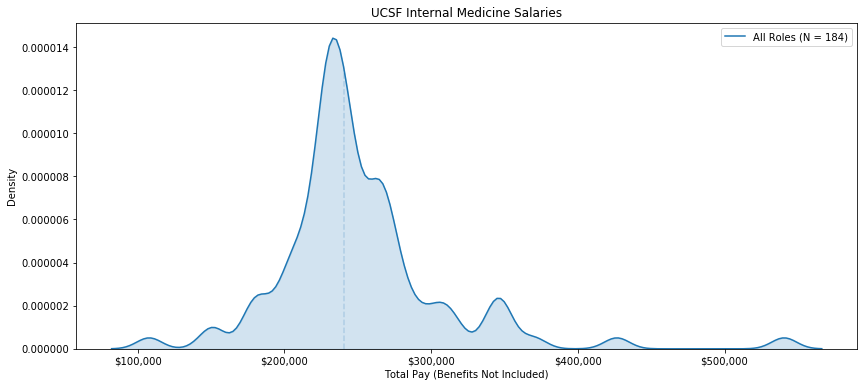

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))
shaded_kde_plot(found_providers["total_pay"],
                label=f"All Roles (N = {len(found_providers):,})", ax=ax, bw = 0.15)

# sns.histplot(found_providers["total_pay"], ax=ax, bins=100)
ax.set_xlabel("Total Pay (Benefits Not Included)")
ax.legend()
ax.set_title(f"UCSF {department.title()} Salaries")

In [15]:
over_write = False
if os.path.exists("transparent_california_data/ucsf_departmental_salary_data_2019.csv") and not over_write:
    all_department_data = pd.read_csv("transparent_california_data/ucsf_departmental_salary_data_2019.csv"
                                     ).drop("index", axis=1)
else:
    all_department_data = []
    pbar = tqdm(DEPARTMENT_URLS, unit=" Department", desc="Webscraping UCSF Departmental Faculty")
    for department in pbar:
        print(department)
        provider_data = get_department_providers(department)
        found_providers = find_provider_salaries(provider_data, salary_data)
        all_department_data.append(found_providers)
    all_department_data = pd.concat(all_department_data)
    all_department_data.to_csv("transparent_california_data/ucsf_departmental_salary_data_2019.csv", index=False)
    
total_data = all_department_data.copy(deep=True)
total_data["department"] = "All Departments"

all_department_data = pd.concat([all_department_data, total_data])

all_department_data = all_department_data.drop_duplicates(subset=["employee_name", "department"])

In [16]:
median_salary_lookup = all_department_data.groupby("department").median()["total_pay"].to_dict()
all_department_data["median_department_total_pay"] = all_department_data["department"].map(median_salary_lookup)
all_department_data = all_department_data.sort_values(["median_department_total_pay", "total_pay"], ascending=True)
all_department_data["Training"] = all_department_data["degree"].apply(lambda degree: "MD PhD"
                                                                      if "phd" in degree.lower() else "MD")

Text(0.5, 1.0, 'UCSF Faculty Physician Salaries')

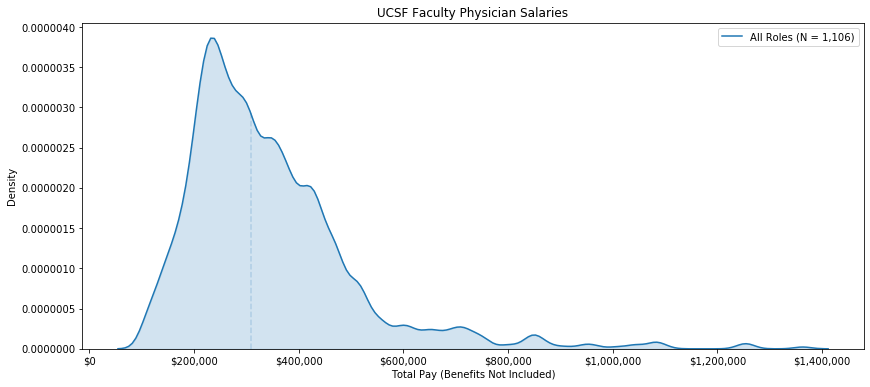

In [17]:
fig, ax = plt.subplots(figsize=(14, 6))
data = all_department_data.query("department == 'All Departments'")
shaded_kde_plot(all_department_data.query("department == 'All Departments'")["total_pay"],
                label=f"All Roles (N = {len(data):,})", ax=ax, bw = 0.10)

ax.set_xlabel("Total Pay (Benefits Not Included)")
ax.legend()
ax.set_title("UCSF Faculty Physician Salaries")

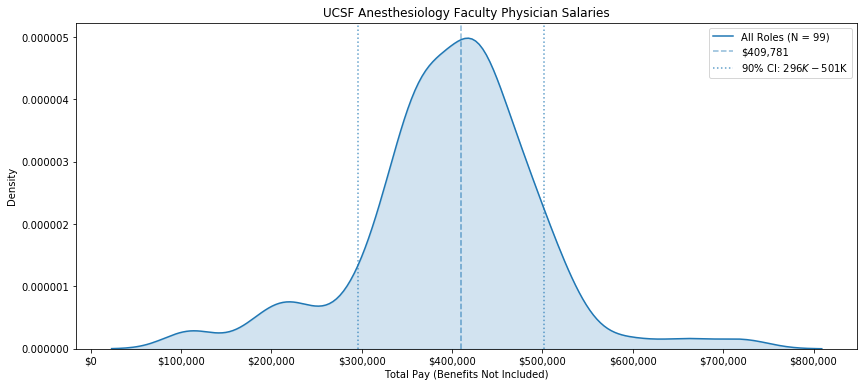

FileNotFoundError: [Errno 2] No such file or directory: 'ucsf_salary_plots/departmental_plots/ucsf_anesthesiology_salary_distribution.png'

In [18]:
import itertools
palette = itertools.cycle(sns.color_palette())

for department in sorted(all_department_data["department"].unique()):
    if department == "All Departments":
        continue

    fig, ax = plt.subplots(figsize=(14, 6))
    data = all_department_data.query(f"department == '{department}'")
    color = next(palette)
    shaded_kde_plot(data["total_pay"],
                    label=f"All Roles (N = {len(data):,})", ax=ax, bw = 0.30, color=color)
    median = data["total_pay"].median()
    std = data["total_pay"].std()
    percent_10 = np.percentile(data["total_pay"], 10)
    percent_90 = np.percentile(data["total_pay"], 90)
    ax.axvline(median, label=f"${median:,.0f}", color=color, linestyle="--", alpha=.5)
    ax.axvline(percent_10, linestyle=":", color=color, alpha=.7, label = f"90% CI: ${percent_10 / 1000:,.0f}K - ${percent_90 / 1000:,.0f}K")
    ax.axvline(percent_90, linestyle=":", color=color, alpha=.7)

    ax.set_xlabel("Total Pay (Benefits Not Included)")
    ax.legend()
    ax.set_title(f"UCSF {department.title()} Faculty Physician Salaries")
    plt.show()
    filename = department.replace("/", "").replace(' ', '_')
    fig.savefig(f"ucsf_salary_plots/departmental_plots/ucsf_{filename}_salary_distribution.png")

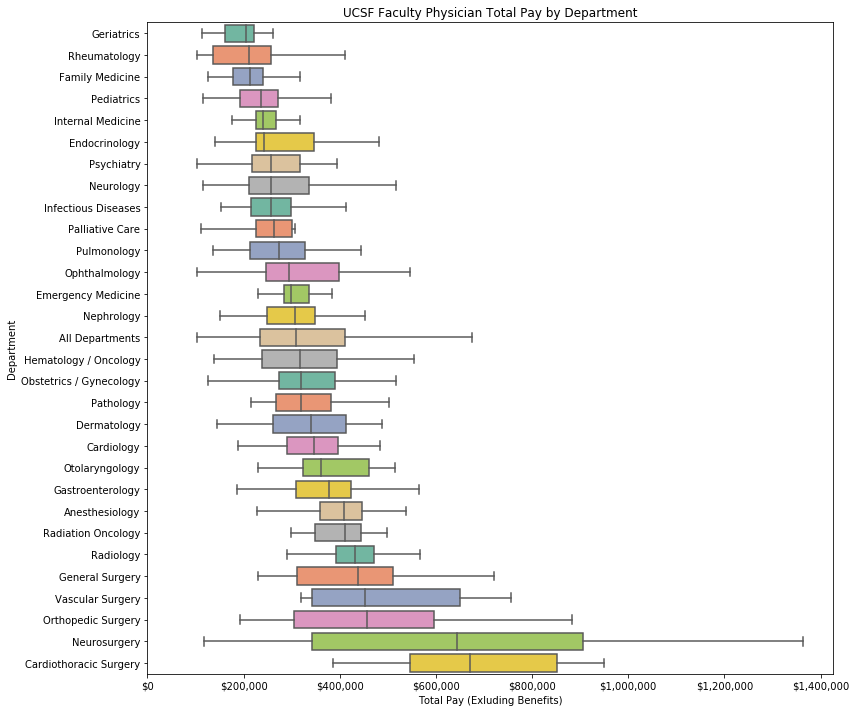

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(data=all_department_data, x="total_pay", y="department", ax=ax, palette="Set2", orient="h", showfliers=False)
ax.set_xlabel("Total Pay (Exluding Benefits)")
ax.set_ylabel("Department")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
ax.set_yticklabels([label._text.title() for label in ax.get_yticklabels()])
ax.set_title("UCSF Faculty Physician Total Pay by Department")
ax.set_xlim(0, None)
fig.tight_layout()
fig.savefig("plots/ucsf_department_salaries.png")

No handles with labels found to put in legend.


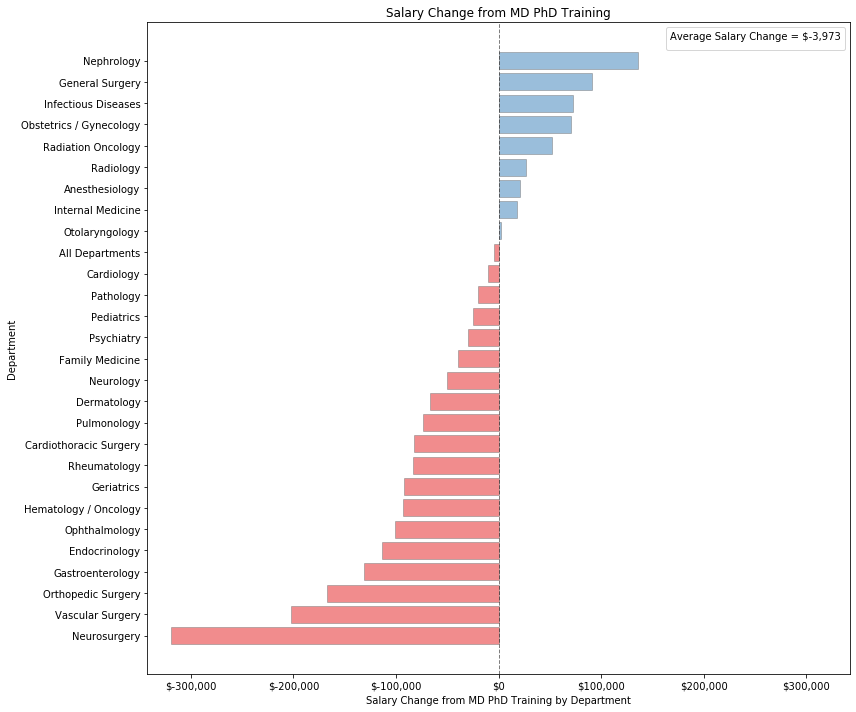

In [21]:
training_pay_differences = all_department_data.query("Training == 'MD PhD'").groupby("department").median()["total_pay"] - all_department_data.query("Training == 'MD'").groupby("department").median()["total_pay"]

training_pay_differences = training_pay_differences.sort_values().dropna()
palette = sns.color_palette("Set1")
colors = [palette[1] if i > 0 else palette[0] for i in training_pay_differences.values]

fig, ax = plt.subplots(figsize=(12, 10))
plt.barh(training_pay_differences.index, width=training_pay_differences.values, edgecolor="gray",
         left=0, color=colors, alpha=.5)
ax.axvline(0, linestyle="--", color="k", alpha=0.5, linewidth=1)
ax.set_xlabel("Salary Change from MD PhD Training by Department")
ax.set_ylabel("Department")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
ax.set_yticklabels([label.title() for label in training_pay_differences.index])
ax.set_title("Salary Change from MD PhD Training")
ax.set_xlim(None, abs(ax.get_xlim()[0]))
ax.legend(title=f"Average Salary Change = ${training_pay_differences['All Departments']:,.0f}")
fig.tight_layout()
fig.savefig("plots/ucsf_md_phd_training_salary_differences.png")

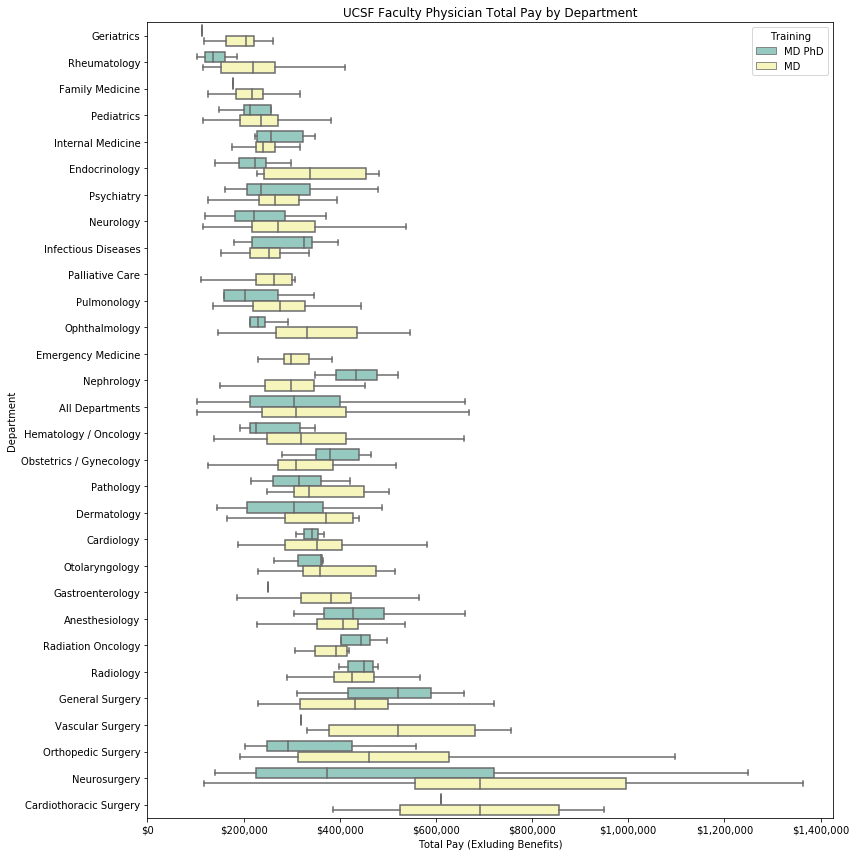

In [23]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.boxplot(data=all_department_data, x="total_pay", y="department", ax=ax, hue="Training",
            orient="h", showfliers=False, palette="Set3")
ax.set_xlabel("Total Pay (Exluding Benefits)")
ax.set_ylabel("Department")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
ax.set_yticklabels([label._text.title() for label in ax.get_yticklabels()])
ax.set_title("UCSF Faculty Physician Total Pay by Department")
ax.set_xlim(0, None)
fig.tight_layout()
fig.savefig("ucsf_salary_plots/ucsf_department_salaries_by_training.png")

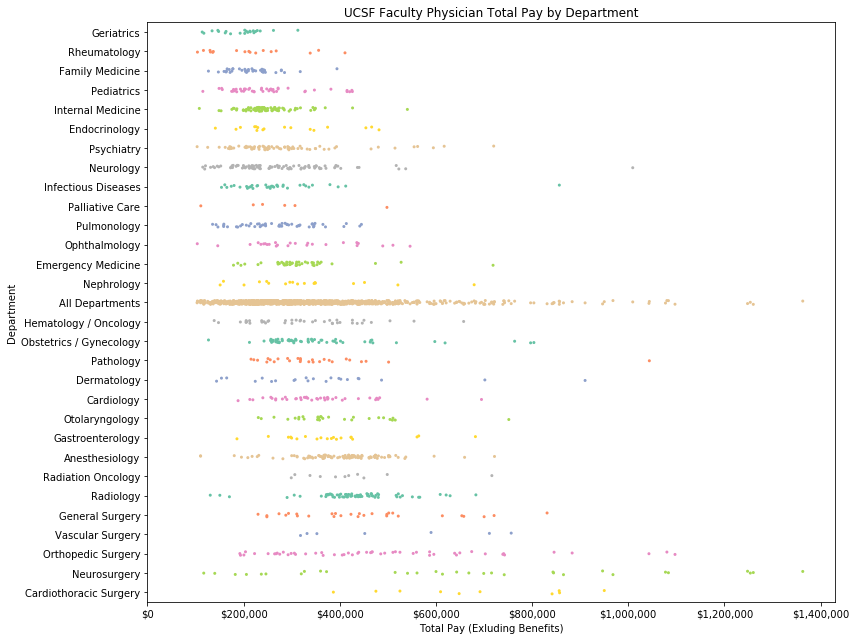

In [22]:
fig, ax = plt.subplots(figsize=(12, 9))

sns.stripplot(data=all_department_data, x="total_pay", y="department", ax=ax, palette="Set2",
              orient="h", dodge=True, size=3)
ax.set_xlabel("Total Pay (Exluding Benefits)")
ax.set_ylabel("Department")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("${x:,.0f}"))
ax.set_yticklabels([label._text.title() for label in ax.get_yticklabels()])
ax.set_title("UCSF Faculty Physician Total Pay by Department")
ax.set_xlim(0, None)
fig.tight_layout()
fig.savefig("plots/ucsf_department_salaries_strip.png")

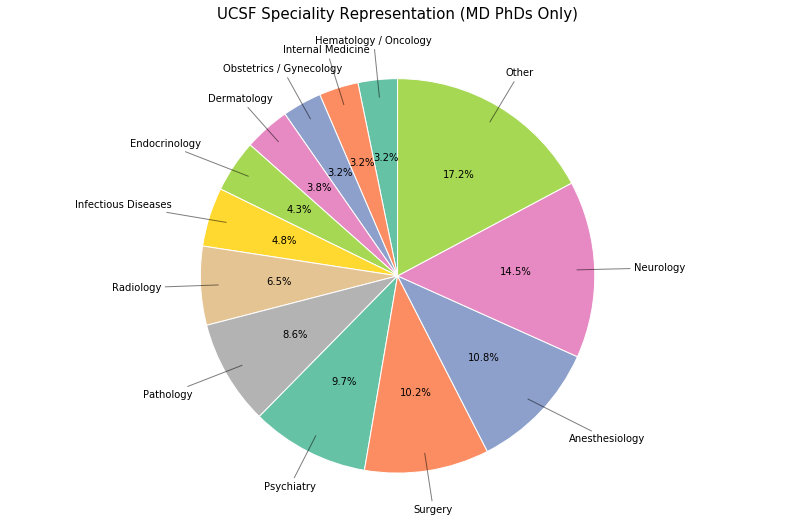

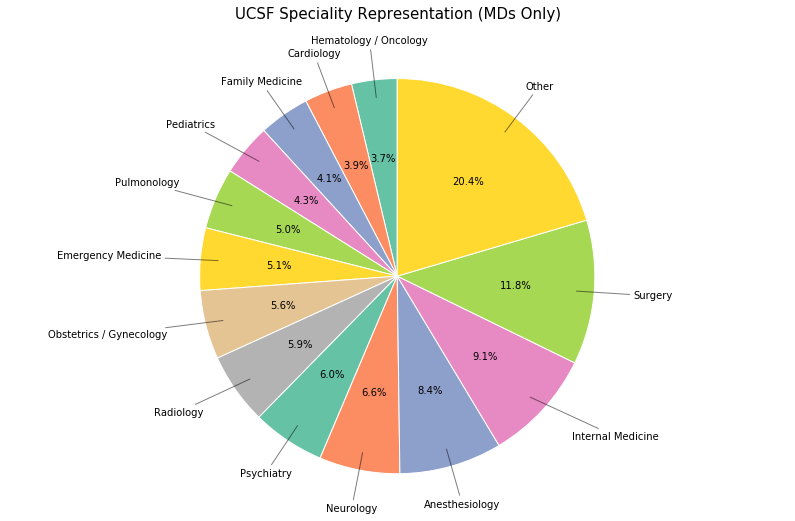

In [23]:
raw_counts = []
for command, training_label in zip(["Training == 'MD PhD'", "Training != 'MD PhD'"], ["MD PhDs Only", "MDs Only"]):

    counts = all_department_data.query(f"{command} and department != 'All Departments'"
                                      ).groupby("department").count()[["name"]]

    counts /= np.sum(counts)
    raw_counts.append(counts.copy(deep=True))
    counts = counts.reset_index()
    surgery_rows = counts["department"].apply(lambda s: "surgery" in s)
    surgery_counts = np.sum(counts["name"].values[surgery_rows])
    counts = counts.loc[~surgery_rows]
    counts = counts.append(dict(zip(["department", "name"], ["surgery", surgery_counts])), ignore_index=True)

    low_rows = counts["name"].values < .03
    low_counts = np.sum(counts["name"].values[low_rows])

    counts = counts.loc[~low_rows]
    counts = counts.append(dict(zip(["department", "name"], ["other", low_counts])), ignore_index=True)



    counts.sort_values("name", inplace=True)
    labels=[s.title() for s in counts["department"].values]

    fig, ax = plt.subplots(figsize=(14, 8))
    wedges, texts, _ = ax.pie(counts["name"].values,
                           autopct='%1.1f%%', startangle=90, shadow=False,
                           colors=sns.color_palette("Set2"), wedgeprops=dict(width=1, edgecolor='w'))
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    kw = dict(arrowprops=dict(arrowstyle="-", alpha=.5, linestyle="-"), va="center", alpha=1)
    for p, label in zip(wedges, labels):
        ang = np.deg2rad((p.theta1 + p.theta2)/2)
        y = np.sin(ang)
        x = np.cos(ang)
        horizontalalignment = "center" if abs(x) < abs(y) else "right" if x < 0 else "left"
        ax.annotate(label, xy=(0.9*x, 0.9*y), xytext=(1.2*x, 1.2*y),
                    horizontalalignment=horizontalalignment, **kw)

    ax.set_title(f"UCSF Speciality Representation ({training_label})", pad=40, size=15)
    fig.savefig(f"plots/ucsf_{training_label.split('s')[0].replace(' ', '_').lower()}_training_representation.png")

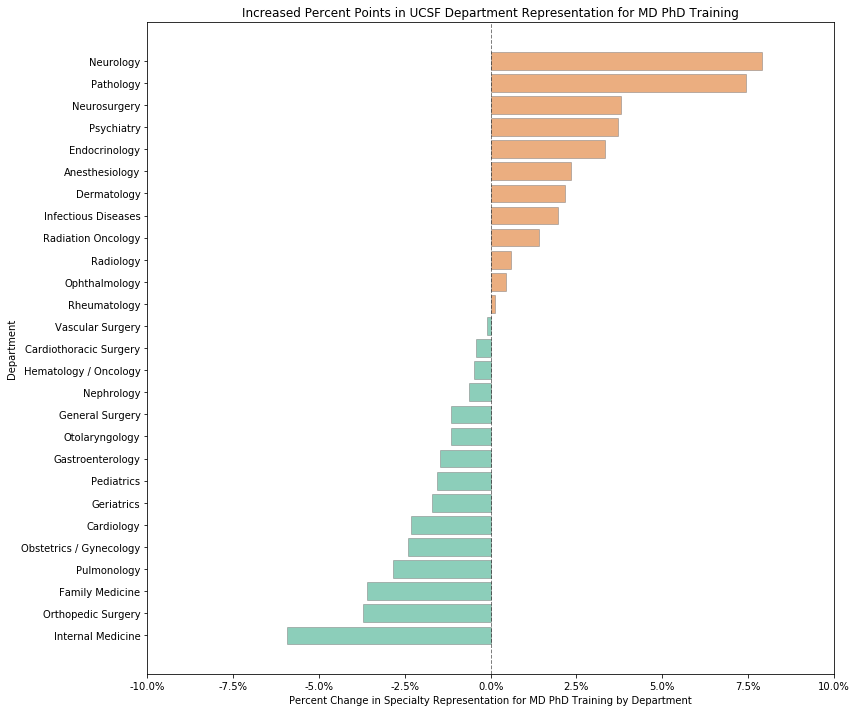

In [25]:
training_representation_differences = (raw_counts[0] - raw_counts[1])["name"].sort_values().dropna()

palette = sns.color_palette("Dark2")
colors = [palette[1] if i > 0 else palette[0] for i in training_representation_differences.values]

fig, ax = plt.subplots(figsize=(12, 10))
plt.barh(training_representation_differences.index,
         width=training_representation_differences.values * 100, edgecolor="gray",
         left=0, color=colors, alpha=.5)
ax.axvline(0, linestyle="--", color="k", alpha=0.5, linewidth=1)
ax.set_xlabel("Percent Change in Specialty Representation for MD PhD Training by Department")
ax.set_ylabel("Department")
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.01f}%"))
ax.set_yticklabels([label.title() for label in training_representation_differences.index])
ax.set_title("Increased Percent Points in UCSF Department Representation for MD PhD Training")

max_x = round(abs(max(ax.get_xlim())) / 100, 1) * 100
ax.set_xlim(- max_x, max_x)
fig.tight_layout()
fig.savefig("plots/ucsf_md_phd_training_representation_differences.png")